# Setup

In [1]:
%autoreload 2
%load_ext autoreload
%matplotlib widget

import sys, os, pickle, pdb, shutil, re, math, glob
from copy import deepcopy, copy
from pathlib import Path
from pprint import pprint
from typing import Union, Callable
from dataclasses import dataclass

import psutil
from tqdm.notebook import tqdm
import pandas as pd, numpy as np, torch, matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter

from optimizing_for_explainability.penalty_functions import mse_penalty, exact_penalty, super_exact_penalty
from optimizing_for_explainability.penalties import LIME_penalty, SHAP_penalty
from optimizing_for_explainability.fairness_metrics import fairness_metric

# import the shap module
paths = [Path("").parent.absolute() / "shap", Path("").parent.absolute() / "shap_original"]
for path in paths:
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))
import shap, shap_original

# set the global dtype and device to work with
DTYPE, DEVICE = torch.float32, torch.device("cuda")
TOPTS = dict(dtype=DTYPE, device=DEVICE)  # tensor options

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Preprocess the data
df = pd.read_csv(Path("") / "data" / "compas" / "cox-violent-parsed_filt.csv")

# Filter out entries with no indication of recidivism or no compass score
df = df[df["is_recid"] != -1]

df = df[df["decile_score"] != -1]
# Rename recidivism column
df["recidivism_within_2_years"] = df["is_recid"]

# Make the COMPASS label column numeric (0 and 1), for use in our model
df["COMPASS_determination"] = np.where(df["score_text"] == "Low", 0, 1)

df = pd.get_dummies(df, columns=["sex", "race"])

# Get list of all columns from the dataset we will use for model input or output.
input_features = [
    "sex_Female",
    "sex_Male",
    "age",
    "race_African-American",
    "race_Caucasian",
    "race_Hispanic",
    "race_Native American",
    "race_Other",
    "priors_count",
    "juv_fel_count",
    "juv_misd_count",
    "juv_other_count",
]

to_keep = input_features + ["recidivism_within_2_years", "COMPASS_determination"]

to_remove = [col for col in df.columns if col not in to_keep]
df = df.drop(columns=to_remove)

input_columns = df.columns.tolist()
labels = df["COMPASS_determination"]

# Create data structures needing for training and testing.
# The training data doesn't contain the column we are predicting,
# 'COMPASS_determination', or the column we are using for evaluation of our
# trained model, 'recidivism_within_2_years'.
df_for_training = df.drop(columns=["COMPASS_determination", "recidivism_within_2_years"])
train_size = int(len(df_for_training) * 0.8)

train_data = df_for_training[:train_size]
train_labels = labels[:train_size]
test_data = df_for_training[train_size:]
test_labels = labels[train_size:]

test_data_with_labels = df[train_size:]

# extract the data into datasets and data loaders ##############################
Xtr, Ytr = train_data.values, train_labels.values
Xts, Yts = test_data.values, test_labels.values
MU, STD = np.mean(Xtr, -2), np.std(Xtr, -2)
normalize_fn = lambda x: (x - MU[None, ...]) / STD[None, ...]
Xtr = normalize_fn(Xtr)
Xts = normalize_fn(Xts)
train_loader = torch.utils.data.DataLoader(list(zip(*[Xtr, Ytr])), batch_size=1024, num_workers=0)
test_loader = torch.utils.data.DataLoader(list(zip(*[Xts, Yts])), batch_size=1024, num_workers=0)

# define protected variables
race_labels, RACE_IDX = zip(
    *[(z, i) for (i, z) in enumerate(train_data.columns) if re.match(r"race_.*", z) is not None]
)

In [3]:
def generate_model(config):
    # This is the size of the array we'll be feeding into our model for each example
    input_size = len(train_data.iloc[0])
    activation = torch.nn.Softplus(1e1)

    model = (
        torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            copy(activation),
            torch.nn.Linear(128, 128),
            copy(activation),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid(),
        )
        .to(DTYPE)
        .to(DEVICE)
    )
    loss_obj = torch.nn.BCELoss()

    def loss_fn(Yp, Y, **kw):
        kw = dict(config, **kw)
        loss = loss_obj(Yp, Y)
        loss = loss + sum(config["lam"] * torch.sum(param**2) / 2 for param in model.parameters())
        return loss

    def cstr_fn(**kw):
        kw = dict(config, **kw)
        penalty_fn = lambda x: exact_penalty(x, kw.get("gam", None))

        if kw.get("method", "").lower() == "lime":
            loss_penalty = LIME_penalty(
                RACE_IDX,
                model,
                train_loader.dataset,
                STD,
                penalty_fn=penalty_fn,
                test_samples=kw["test_samples"],
                bg_samples=kw["bg_samples"],
                sample_std=kw["sample_std"],
            )
        elif kw.get("method", "").lower() == "shap":
            loss_penalty = SHAP_penalty(
                RACE_IDX,
                model,
                train_loader.dataset,
                penalty_fn=penalty_fn,
                test_samples=kw["test_samples"],
                bg_samples=kw["bg_samples"],
            )
        else:
            return (0, (None for _ in model.parameters()))
        return loss_penalty

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)
    return model, loss_fn, cstr_fn, optimizer, scheduler


def accuracy(model, loader):
    correct = 0
    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(DTYPE).to(DEVICE), Y.to(DEVICE)
            Yp = model(X)
            correct += torch.sum((Yp > 0.5).reshape(Y.shape) == Y).detach()
    return correct / len(loader.dataset)

# LIME Experiments

In [28]:
model_idx = 0


def main(config):
    global model_idx
    model, loss_fn, cstr_fn, optimizer, scheduler = generate_model(config)
    shutil.rmtree(Path("") / "runs")
    writer = SummaryWriter()
    hist = dict()
    rng = tqdm(range(int(20)))
    step = -1
    for epoch in rng:
        for (i, (X, Y)) in enumerate(train_loader):
            step += 1
            X, Y = X.to(DTYPE).to(DEVICE), Y.to(DTYPE).to(DEVICE)  # sample a batch
            optimizer.zero_grad()  # zero gradients
            cstr_val, grads = cstr_fn()
            for (grad, param) in zip(grads, model.parameters()):
                if grad is not None:
                    param.grad = grad
            if config.get("method", "").lower() == "masked":
                X[..., RACE_IDX] = X[..., RACE_IDX] * 0
            loss = loss_fn(model(X).reshape(Y.shape), Y)
            loss.backward()

            optimizer.step()
            writer.add_scalar("loss/train", float(loss), step)
            writer.add_scalar("step_size", float(optimizer.param_groups[0]["lr"]), step)
            writer.add_scalar("penalty_metric", float(cstr_val), step)
            hist.setdefault("train_loss", []).append(float(loss))
            hist.setdefault("penalty_metric", []).append(float(cstr_val))
            writer.flush()
        scheduler.step()
        test_acc = accuracy(model, test_loader)
        train_acc = accuracy(model, train_loader)
        hist.setdefault("test_acc", []).append(float(test_acc))
        hist.setdefault("train_acc", []).append(float(train_acc))
        rng.set_description(f"Accuracy = (test = {1e2 * test_acc:.3f}%, train = {1e2 * train_acc:.3f}%)")
        writer.add_scalar("acc/train", float(train_acc), step)
        writer.add_scalar("acc/test", float(test_acc), step)
    fname = Path("") / "data" / f"compas_model_snap_{model_idx}.bin"
    model_idx += 1
    torch.save((config, hist, model), fname)


model_idx = 3
configs = [
    # dict(lam=1e-3),
    # dict(test_samples=int(1e2), bg_samples=int(1e3), sample_std=1e-2, method="LIME", lam=1e-3, gam=1e1),
    # dict(test_samples=int(1e1), bg_samples=int(1e2), method="SHAP", lam=1e-3, gam=1e1),
    dict(lam=1e-3, method="masked"),
]
for config in configs:
    main(config)

  0%|          | 0/20 [00:00<?, ?it/s]

## Generate Accuracy vs Penalty Strength Graph

### LIME

In [6]:
shutil.rmtree(Path("") / "runs")

def check_gam(config):
    model, loss_fn, cstr_fn, optimizer, scheduler = generate_model(config)
    #shutil.rmtree(Path("") / "runs")
    writer = SummaryWriter()
    rng = tqdm(range(int(15)))
    test_acc, step, hist = 0, -1, dict()
    for epoch in rng:
        for (i, (X, Y)) in enumerate(train_loader):
            step += 1
            X, Y = X.to(DTYPE).to(DEVICE), Y.to(DTYPE).to(DEVICE)  # sample a batch
            optimizer.zero_grad()  # zero gradients
            cstr_val, grads = cstr_fn()
            for (grad, param) in zip(grads, model.parameters()):
                if grad is not None:
                    param.grad = grad
            loss = loss_fn(model(X).reshape(Y.shape), Y)
            loss.backward()

            optimizer.step()
            writer.add_scalar("loss/train", float(loss), step)
            writer.add_scalar("step_size", float(optimizer.param_groups[0]["lr"]), step)
            writer.add_scalar("penalty_metric", float(cstr_val), step)
            hist.setdefault("train_loss", []).append(float(loss))
            hist.setdefault("penalty_metric", []).append(float(cstr_val))
            writer.flush()
        scheduler.step()
        test_acc = accuracy(model, test_loader)
        train_acc = accuracy(model, train_loader)
        hist.setdefault("test_acc", []).append(float(test_acc))
        hist.setdefault("train_acc", []).append(float(train_acc))
        rng.set_description(f"Accuracy = (test = {1e2 * test_acc:.3f}%, train = {1e2 * train_acc:.3f}%)")
        writer.add_scalar("acc/train", float(train_acc), step)
        writer.add_scalar("acc/test", float(test_acc), step)
        
    cstr_vals = []
    for _ in range(5):
        cstr_val, _ = LIME_penalty(
                RACE_IDX,
                model,
                train_loader.dataset,
                STD,
                penalty_fn=lambda x: exact_penalty(x, gam=config["gam"]),
                test_samples=config["test_samples"],
                bg_samples=config["bg_samples"],
                sample_std=config["sample_std"],
            )
        cstr_vals.append(float(cstr_val))
    return np.mean(cstr_vals) / config["gam"], test_acc, hist


lime_gams = 10.0 ** np.linspace(-2, 2, 10)
config = dict(test_samples=int(1e2), bg_samples=int(1e3), sample_std=1e-2, method="LIME", lam=1e-3, gam=1e1)
lime_rets = [check_gam(dict(config, gam=gam)) for gam in lime_gams]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
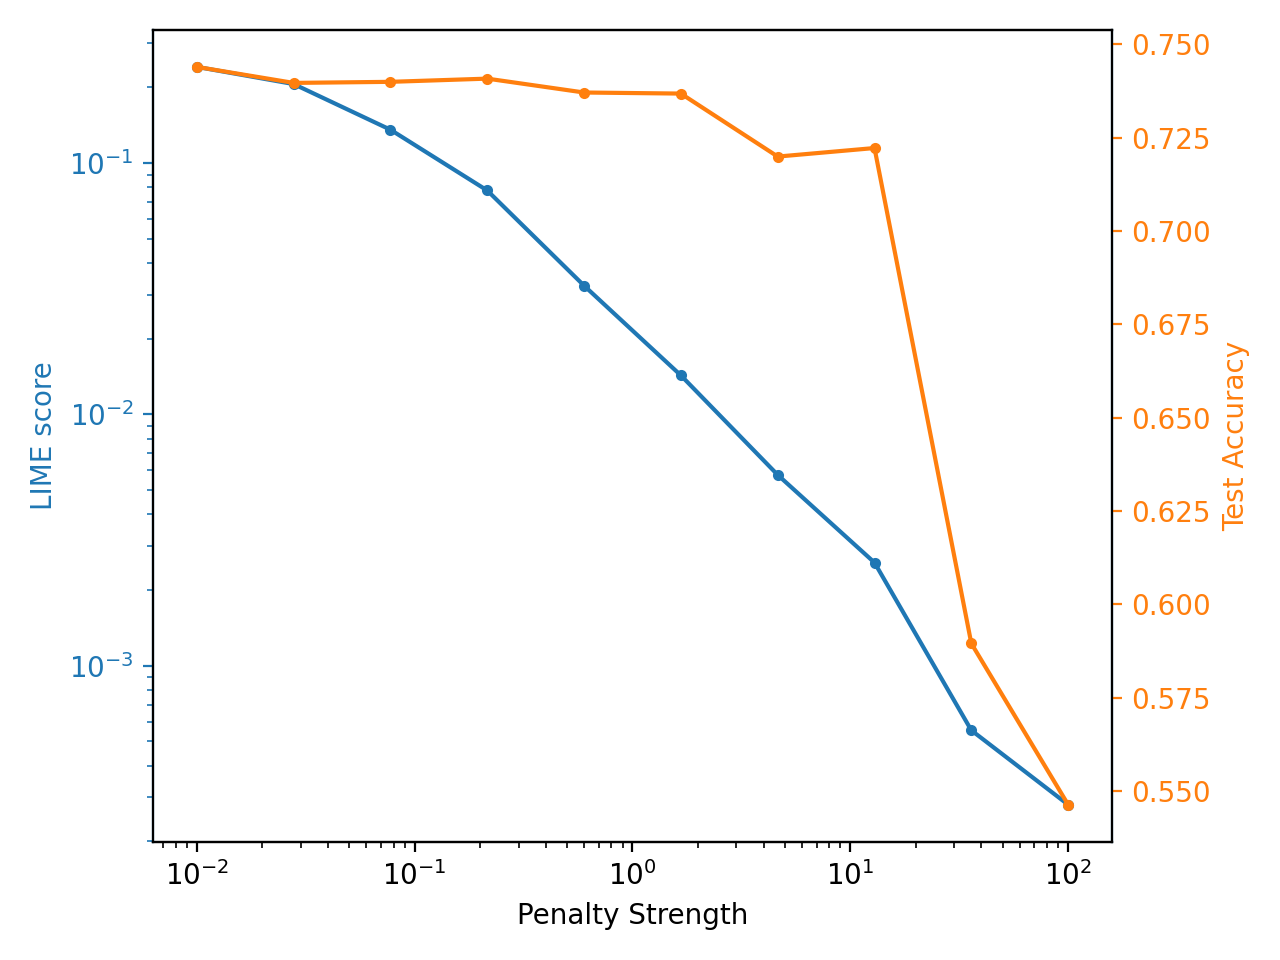

In [12]:
score = [float(ret[0]) for ret in lime_rets]
accs = [float(ret[1]) for ret in lime_rets]

fig, axs = plt.subplots(1, 1) 
axs = [axs] 
axs[0].plot(lime_gams, score, marker=".", color="C0") 
axs[0].set_ylabel("LIME score", color="C0") 
axs[0].set_xlabel("Penalty Strength") 
axs[0].set_yscale("log") 
axs[0].set_xscale("log") 
axs[0].spines["left"].set_color("C0") 
axs[0].spines["right"].set_color("C0") 
axs[0].tick_params(axis="y", colors="C0", which="both") 
 
ax = axs[0].twinx() 
ax.plot(gams, accs, marker=".", color="C1") 
#ax.set_yscale("log") 
 
ax.set_ylabel("Test Accuracy", color="C1") 
#ax.spines["right"].set_color("C1") 
ax.tick_params(axis="y", colors="C1") 
 
#axs[1].loglog(lime_score, accs, marker=".") 
 
plt.tight_layout() 
plt.savefig("figures/lime_reg.png", dpi=200, bbox_inches="tight")
plt.show()

In [5]:
if (Path("") / "runs").exists():
    shutil.rmtree(Path("") / "runs")

def check_gam(config):
    model, loss_fn, cstr_fn, optimizer, scheduler = generate_model(config)
    #shutil.rmtree(Path("") / "runs")
    writer = SummaryWriter()
    rng = tqdm(range(int(15)))
    test_acc, step, hist = 0, -1, dict()
    for epoch in rng:
        for (i, (X, Y)) in enumerate(train_loader):
            step += 1
            X, Y = X.to(DTYPE).to(DEVICE), Y.to(DTYPE).to(DEVICE)  # sample a batch
            optimizer.zero_grad()  # zero gradients
            cstr_val, grads = cstr_fn()
            for (grad, param) in zip(grads, model.parameters()):
                if grad is not None:
                    param.grad = grad
            loss = loss_fn(model(X).reshape(Y.shape), Y)
            loss.backward()

            optimizer.step()
            writer.add_scalar("loss/train", float(loss), step)
            writer.add_scalar("step_size", float(optimizer.param_groups[0]["lr"]), step)
            writer.add_scalar("penalty_metric", float(cstr_val), step)
            hist.setdefault("train_loss", []).append(float(loss))
            hist.setdefault("penalty_metric", []).append(float(cstr_val))
            writer.flush()
        scheduler.step()
        test_acc = accuracy(model, test_loader)
        train_acc = accuracy(model, train_loader)
        hist.setdefault("test_acc", []).append(float(test_acc))
        hist.setdefault("train_acc", []).append(float(train_acc))
        rng.set_description(f"Accuracy = (test = {1e2 * test_acc:.3f}%, train = {1e2 * train_acc:.3f}%)")
        writer.add_scalar("acc/train", float(train_acc), step)
        writer.add_scalar("acc/test", float(test_acc), step)
        
    cstr_vals = []
    for _ in range(5):
        cstr_val, _ = SHAP_penalty(
                RACE_IDX,
                model,
                train_loader.dataset,
                penalty_fn=lambda x: exact_penalty(x, gam=config["gam"]),
                test_samples=config["test_samples"],
                bg_samples=config["bg_samples"],
            )
        cstr_vals.append(float(cstr_val))
    return np.mean(cstr_vals) / config["gam"], test_acc, hist


shap_gams = 10.0 ** np.linspace(-2, 3, 10)
config =  dict(test_samples=int(1e1), bg_samples=int(1e2), method="SHAP", lam=1e-3, gam=1e1)
shap_rets = [check_gam(dict(config, gam=gam)) for gam in shap_gams]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
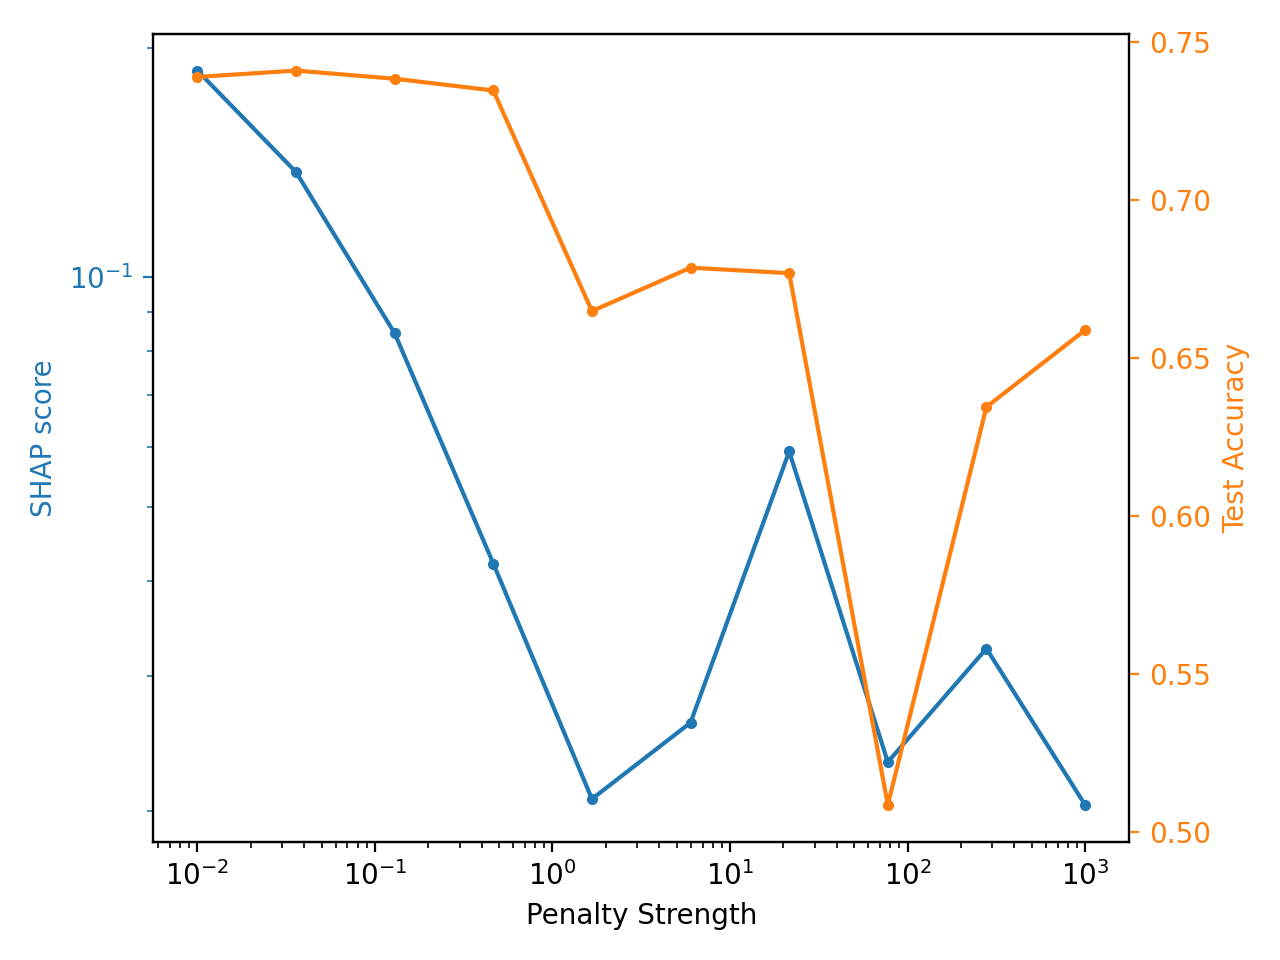

In [7]:
score = [float(ret[0]) for ret in shap_rets]
accs = [float(ret[1]) for ret in shap_rets]

fig, axs = plt.subplots(1, 1) 
axs = [axs] 
axs[0].plot(shap_gams, score, marker=".", color="C0") 
axs[0].set_ylabel("SHAP score", color="C0") 
axs[0].set_xlabel("Penalty Strength") 
axs[0].set_yscale("log") 
axs[0].set_xscale("log") 
axs[0].spines["left"].set_color("C0") 
axs[0].spines["right"].set_color("C0") 
axs[0].tick_params(axis="y", colors="C0", which="both") 
 
ax = axs[0].twinx() 
ax.plot(shap_gams, accs, marker=".", color="C1") 
#ax.set_yscale("log") 
 
ax.set_ylabel("Test Accuracy", color="C1") 
#ax.spines["right"].set_color("C1") 
ax.tick_params(axis="y", colors="C1") 
 
#axs[1].loglog(lime_score, accs, marker=".") 
 
plt.tight_layout() 
plt.savefig("figures/shap_reg.png", dpi=200, bbox_inches="tight")
plt.show()

--------------------------------------------------------------------------------

# Evaluate models trained

In [5]:
paths = glob.glob(str(Path("").absolute() / "data" / "compas_model_snap_*.bin"))
acc_df = pd.DataFrame(
    {
        "Name": [],
        "Train Accuracy": [],
        "Test Accuracy": [],
        "LIME Penalty Value": [],
        "SHAP Penalty Value": [],
        "TNR (std)": [],
        "TPR (std)": [],
        "Dem. Parity (std)": [],
        "Pred. Parity (std)": [],
        "Accuracy (std)": [],
    }
)

gam, sample_std, bg_samples, test_samples = None, None, None, None

LIME_test_samples, LIME_bg_samples, LIME_sample_std, LIME_gam = int(1e2), int(1e3), 1e-2, 1e1
SHAP_test_samples, SHAP_bg_samples, SHAP_gam = int(1e1), int(1e2), 1e1


for path in paths:
    (config, hist, model) = torch.load(path)

    groups = np.round((Xtr * STD + MU)[:, RACE_IDX]).astype(np.int64)
    Yp = model(torch.as_tensor(Xtr, **TOPTS)).cpu().detach().numpy().reshape(-1)
    fair_df = pd.DataFrame(
        dict({race_label: groups[:, i] for (i, race_label) in enumerate(race_labels)}, prediction=Yp, label=Ytr)
    )
    res = fairness_metric(fair_df, race_labels)

    LIME_penalty_vals = []
    for i in tqdm(range(10)):
        penalty_val, _ = LIME_penalty(
            RACE_IDX,
            model,
            train_loader.dataset,
            STD,
            penalty_fn=lambda x: exact_penalty(x, LIME_gam),
            test_samples=LIME_test_samples,
            bg_samples=LIME_bg_samples,
            sample_std=LIME_sample_std,
        )
        LIME_penalty_vals.append(float(penalty_val))
    LIME_penalty_val = np.mean(LIME_penalty_vals)

    SHAP_penalty_vals = []
    for i in tqdm(range(10)):
        penalty_val, _ = SHAP_penalty(
            RACE_IDX,
            model,
            train_loader.dataset,
            penalty_fn=lambda x: exact_penalty(x, SHAP_gam),
            test_samples=SHAP_test_samples,
            bg_samples=SHAP_bg_samples,
        )
        SHAP_penalty_vals.append(float(penalty_val))
    SHAP_penalty_val = np.mean(SHAP_penalty_vals)

    acc_df.loc[len(acc_df)] = [
        {"LIME": "LIME Penalized", "SHAP": "SHAP Penalized", "": "Baseline", "masked": "Masked"}[
            config.get("method", "")
        ],
        float(hist["train_acc"][-1]),
        float(hist["test_acc"][-1]),
        float(LIME_penalty_val),
        float(SHAP_penalty_val),
        float(np.std(res["tnr"])),
        float(np.std(res["tpr"])),
        float(np.std(res["mean"])),
        float(np.std(res["prec"])),
        float(np.std(res["acc"])),
    ]
acc_df

Equalized Odds
Groups TP rate:0.566	0.324	0.282	0.488	0.231
Groups TN rate:0.159	0.380	0.406	0.279	0.423

Equality of Opportunity
Groups TP rate:0.566	0.324	0.282	0.488	0.231

Demographic Parity
Group predicted positive rate:0.569	0.504	0.502	0.544	0.500

Predictive Parity
Group precision :0.751503	0.616926	0.540146	0.700000	0.421918

Accuracy
Group accuracy:0.724694	0.703775	0.687619	0.767442	0.653673



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Equalized Odds
Groups TP rate:0.563	0.268	0.215	0.419	0.097
Groups TN rate:0.187	0.483	0.568	0.488	0.676

Equality of Opportunity
Groups TP rate:0.563	0.268	0.215	0.419	0.097

Demographic Parity
Group predicted positive rate:0.650	0.419	0.354	0.496	0.264

Predictive Parity
Group precision :0.780033	0.731107	0.733766	1.000000	0.607477

Accuracy
Group accuracy:0.750133	0.750322	0.782857	0.906977	0.773613



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Equalized Odds
Groups TP rate:0.525	0.299	0.268	0.488	0.192
Groups TN rate:0.227	0.440	0.514	0.419	0.576

Equality of Opportunity
Groups TP rate:0.525	0.299	0.268	0.488	0.192

Demographic Parity
Group predicted positive rate:0.603	0.460	0.429	0.531	0.398

Predictive Parity
Group precision :0.815757	0.679512	0.670644	0.875000	0.540084

Accuracy
Group accuracy:0.752664	0.738953	0.781905	0.906977	0.767616



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Equalized Odds
Groups TP rate:0.522	0.240	0.210	0.488	0.118
Groups TN rate:0.227	0.505	0.572	0.349	0.654

Equality of Opportunity
Groups TP rate:0.522	0.240	0.210	0.488	0.118

Demographic Parity
Group predicted positive rate:0.582	0.485	0.476	0.574	0.458

Predictive Parity
Group precision :0.814330	0.759864	0.740741	0.777778	0.580882

Accuracy
Group accuracy:0.749068	0.744959	0.781905	0.837209	0.772114



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


,Name,Train Accuracy,Test Accuracy,LIME Penalty Value,SHAP Penalty Value,TNR (std),TPR (std),Dem. Parity (std),Pred. Parity (std),Accuracy (std)
0,SHAP Penalized,0.711078,0.693078,0.306138,0.264091,0.098757,0.127536,0.027646,0.116918,0.037934
1,Baseline,0.754130,0.743707,2.821069,1.871558,0.162483,0.162309,0.131206,0.128249,0.058529
2,Masked,0.751484,0.725973,3.458052,0.633116,0.117942,0.129792,0.073861,0.117955,0.060414
3,LIME Penalized,0.751412,0.731407,0.030645,0.636613,0.154217,0.160282,0.052112,0.080655,0.033106


In [53]:
def color2hex(col):
    ret = "#"
    for c in col[:3]:
        rep = hex(round(255 * c))[2:]
        ret += "00"[: -len(rep)] + rep
    return ret

cdict = {
    "red": (
        (0.0, 1.0, 1.0),
        (1.0, 0.6, 0.6),
    ),
    "blue": (
        (0.0, 0.6, 0.6),
        (1.0, 0.6, 0.6),
    ),
    "green": (
        (0.0, 0.6, 0.6),
        (0.5, 0.7, 0.7),
        (1.0, 1.0, 1.0),
    ),
}
import matplotlib.colors as mcolors
cmap = mcolors.LinearSegmentedColormap("my_colormap", cdict, 100)

print_df = deepcopy(acc_df)
for key in print_df.keys():
    vals = np.array(print_df[key])
    if vals.dtype == np.float64:
        if re.match(r"(Test|Train) Accuracy", key):
            idx = np.argmax(vals)
            cmap_ = cmap
        else:
            idx = np.argmin(vals)
            cmap_ = cmap.reversed()
    else:
        continue
    # cols = [f"\\cellcolor{{{color2hex(cmap(val - np.min(vals)))}}}" for val in vals]
    mapped_vals = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
    cols = [f"\\cellcolor[rgb]{{{', '.join('%.2f' % z for z in cmap_(val)[:3])}}}" for val in mapped_vals]
    vals = [col + (f"{z:.4f}" if i != idx else f"\\textbf{{{z:.4f}}}") for (i, (col, z)) in enumerate(zip(cols, vals))]
    print_df[key] = vals
#print(print_df)
print(re.subn(r"[\t ]+", " ", print_df.to_latex(index=False, escape=False))[0])
# print(print_df.to_latex(index=False))

\begin{tabular}{llllllllll}
\toprule
 Name & Train Accuracy & Test Accuracy & LIME Penalty Value & SHAP Penalty Value & TNR (std) & TPR (std) & Dem. Parity (std) & Pred. Parity (std) & Accuracy (std) \\
\midrule
SHAP Penalized & \cellcolor[rgb]{1.00, 0.60, 0.60}0.7111 & \cellcolor[rgb]{1.00, 0.60, 0.60}0.6931 & \cellcolor[rgb]{0.63, 0.95, 0.60}0.3061 & \cellcolor[rgb]{0.60, 1.00, 0.60}\textbf{0.2641} & \cellcolor[rgb]{0.60, 1.00, 0.60}\textbf{0.0988} & \cellcolor[rgb]{0.60, 1.00, 0.60}\textbf{0.1275} & \cellcolor[rgb]{0.60, 1.00, 0.60}\textbf{0.0276} & \cellcolor[rgb]{0.91, 0.65, 0.60}0.1169 & \cellcolor[rgb]{0.67, 0.90, 0.60}0.0379 \\
 Baseline & \cellcolor[rgb]{0.60, 1.00, 0.60}\textbf{0.7541} & \cellcolor[rgb]{0.60, 1.00, 0.60}\textbf{0.7437} & \cellcolor[rgb]{0.93, 0.64, 0.60}2.8211 & \cellcolor[rgb]{1.00, 0.60, 0.60}1.8716 & \cellcolor[rgb]{1.00, 0.60, 0.60}0.1625 & \cellcolor[rgb]{1.00, 0.60, 0.60}0.1623 & \cellcolor[rgb]{1.00, 0.60, 0.60}0.1312 & \cellcolor[rgb]{1.00, 0.60, 0.60

--------------------------------------------------------------------------------

# Testing differentiating through Shapley Values

### SHAP differentiability test 

In [13]:
# Create a SHAP explainer by passing a subset of our training data
model, loss_fn, optimizer, scheduler, Xs = generate_model()
X_background = torch.as_tensor(Xtr[torch.randperm(Xtr.shape[0])[:100], ...], **TOPTS)
X_test = torch.as_tensor(Xtr[torch.randperm(Xtr.shape[0])[:10], ...], **TOPTS)
explainer = shap.DeepExplainer(model, X_background)

In [30]:
vals1 = explainer.shap_values(X_test)

explainer_original = shap_original.DeepExplainer(deepcopy(model), X_background)
vals2 = torch.as_tensor(explainer_original.shap_values(X_test), **TOPTS)

print(torch.norm(vals1 - vals2) / torch.norm(vals1))

tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)


In [26]:
J2 = torch.autograd.grad(explainer.shap_values(X_test).reshape(-1)[0], next(model.parameters()))[0]
print(J2)
# f = lambda x: explainer.shap_values(x).detach().reshape(-1)[0]
# J = finite_diff(f, X_test, 1e-5)
# X_test.requires_grad = True

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


tensor([[-3.5033e-06,  7.4467e-08, -3.2063e-07,  ...,  7.6408e-08,
          1.4895e-08,  5.8486e-08],
        [-9.7314e-04,  4.6529e-08,  1.4900e-07,  ..., -6.3004e-09,
         -1.2282e-09,  1.9573e-09],
        [ 6.3739e-05,  2.4759e-07, -1.7470e-06,  ...,  2.9007e-07,
          5.6548e-08,  2.2286e-07],
        ...,
        [ 1.4102e-04,  1.7241e-08, -8.3069e-08,  ...,  2.4468e-08,
          4.7699e-09,  2.1345e-08],
        [-5.7081e-06, -1.2926e-08,  2.7734e-07,  ..., -4.1700e-08,
         -8.1292e-09, -3.5948e-08],
        [-5.5522e-05,  2.3477e-08, -2.0407e-07,  ...,  3.3517e-08,
          6.5339e-09,  2.6414e-08]], device='cuda:0')


### Multi-input test (we probably won't need this)

In [ ]:
model, loss_fn, optimizer, scheduler, Xs = generate_model()
X_background = torch.as_tensor(Xtr[torch.randperm(Xtr.shape[0])[:100], ...], **TOPTS)
X_test = torch.as_tensor(Xtr[torch.randperm(Xtr.shape[0])[:10], ...], **TOPTS)
Xb1, Xb2 = X_background[..., :3], X_background[..., 3:]
Xt1, Xt2 = X_test[..., :3], X_test[..., 3:]

explainer = shap.DeepExplainer(deepcopy(model2), [Xb1, Xb2])
vals1 = explainer.shap_values([Xt1, Xt2])

explainer_original = shap_original.DeepExplainer(deepcopy(model2), [Xb1, Xb2])
vals2 = explainer_original.shap_values([Xt1, Xt2])

# print(torch.norm(vals1 - vals2) / torch.norm(vals1))

--------------------------------------------------------------------------------